In [28]:
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import streamlit as st
import random

In [2]:
# Initialize TensorFlow GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


In [3]:
# Load individual models for different conditions
models = {
    'Diabetic': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_diabetic_aug.h5'),
    'Glaucoma': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_glaucoma_aug.h5'),
    'Cataract': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_cataract_aug.h5'),
    'Macular Degeneration': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_macular_degeneration_aug.h5'),
    'Hypertensive': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_hypertensive_aug.h5'),
    'Myopia': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_myopia_aug.h5'),
    'Other': tf.keras.models.load_model('Weights/vgg19_all_datasets_full_df_other_aug.h5')
}

In [13]:
# Function to load and preprocess images
def load_testing_images(directory, image_size):
    images = []
    filenames = []
    for img_filename in os.listdir(directory):
        img_path = os.path.join(directory, img_filename)
        try:
            # Read and resize image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (image_size, image_size))

            # Convert to array and normalize
            #img_array = np.array(img) / 255.0
            images.append(img)
            filenames.append(img_filename)
        except Exception as e:
            print(f"Error loading image {img_filename}: {e}")
    return np.array(images), filenames

In [14]:
# Load testing images
test_images, test_filenames = load_testing_images('Testing Images', 224)

In [15]:
# Check if images are loaded correctly
print(f'Loaded {len(test_images)} images for testing')

Loaded 1000 images for testing


In [16]:
results = {}
confidences = {}

with tf.device('/CPU:0'):
    for name, model in models.items():
        predictions = model.predict(test_images, batch_size=16)
        predicted_categories = (predictions > 0.5).astype(int)
        results[name] = predicted_categories
        confidences[name] = predictions  # Store raw probabilities for confidence display


63/63 [==============================] - 61s 968ms/step


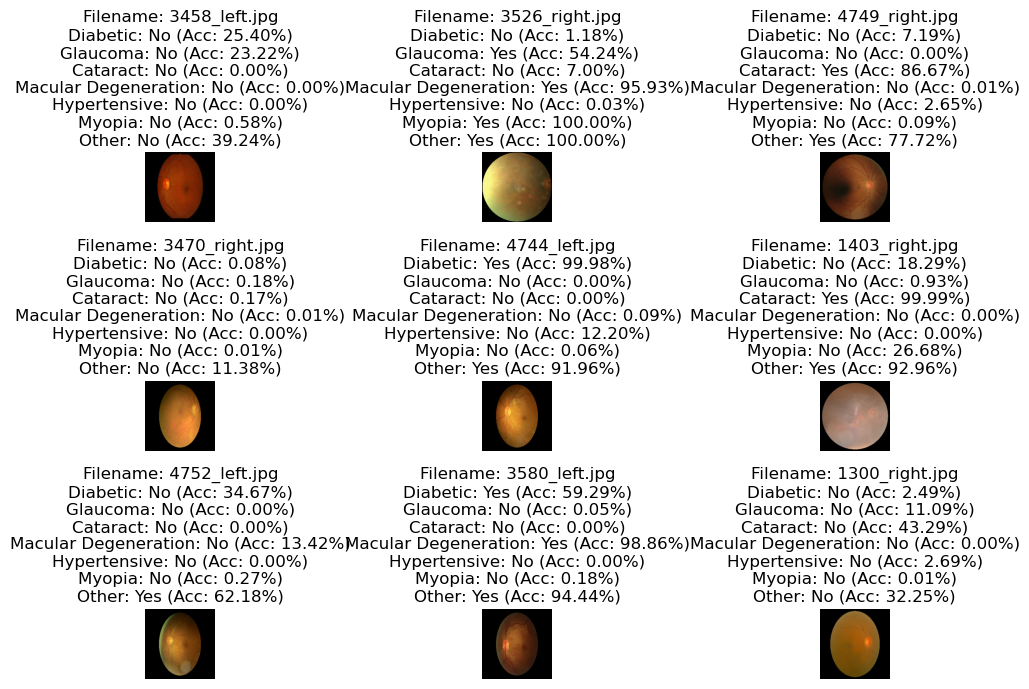

In [36]:
num_images_to_display = min(9, len(test_images))
selected_indices = random.sample(range(len(test_images)), num_images_to_display)

plt.figure(figsize=(12, 7))
for idx, i in enumerate(selected_indices):
    plt.subplot(3, 3, idx + 1)
    test_image = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(test_image)
    plt.axis('off')
    title = f"Filename: {test_filenames[i]}"
    for condition in results:
        pred = 'Yes' if results[condition][i] else 'No'
        acc = confidences[condition][i][0] * 100  # Assuming binary classification, adjust if necessary
        title += f"\n{condition}: {pred} (Acc: {acc:.2f}%)"
    plt.title(title)

# Adjust subplot parameters
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.4, top=1, wspace=0.4, hspace=0.4)

plt.tight_layout()
plt.show()